In [5]:
# %% imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head()

NameError: name 'pd' is not defined

### **Dataset Description – Metro Interstate Traffic Volume**

- This dataset contains **hourly** traffic volume records from a highway station, combined with **weather** and **holiday** information. 
- Each row represents a traffic observation at a given date and time.

### **Features**

holiday: US holiday name if applicable (e.g., Columbus Day), otherwise None.

temp: Temperature in Kelvin (convertible to °C for interpretability).

rain_1h: Amount of rain in the past hour (mm). Mostly zero, but sometimes >0.

snow_1h: Amount of snow in the past hour (mm). Mostly zero.

clouds_all: Cloudiness percentage (0 = clear sky, 100 = fully cloudy).

weather_main: General weather condition (e.g., Clouds, Clear, Rain, Snow, Mist, Haze, Thunderstorm).

weather_description: More detailed description of weather (e.g., “few clouds”, “light rain”).

date_time: Timestamp of the observation (hourly frequency).

traffic_volume (target variable): Number of cars that passed the station during that hour.

### **Observations***

**1. Holiday entries**

Named holidays appear in the holiday column.

Some holidays appear multiple times with different weather records (e.g., Labor Day with Rain and Thunderstorm).

**2. Weather conditions**

Weather descriptions sometimes vary in casing (sky is clear vs Sky is Clear).

Overlapping conditions exist (e.g., Rain + Thunderstorm).

**3.Traffic volume distribution**

Traffic ranges from very low (~0–500) to very high (>7000 in the full dataset).

Peak traffic is usually on workdays during rush hours.

Holidays and severe weather tend to lower traffic.

**4. Temperature (Kelvin)**

Winter values ≈ 260–275 K (~ -13°C to 2°C).

Summer values ≈ 290–300 K (~ 17°C to 27°C).

Matches seasonal expectations.

**5. Date range & frequency**

Data spans 2012 - 2018.

Frequency: hourly observations. (h)

### **Intuition for Modeling**

Time series cycles: Daily and weekly patterns strongly influence traffic (rush hour, weekends).

Weather: Rain, snow, and cloudy days tend to lower traffic.

Holidays: Reduce commuting traffic but may increase leisure travel traffic.

Duplicates with different weather: Not errors, but extra context.

**Summary**
This dataset is like a logbook of city traffic, with each row stating:
"On this date and time, it was X°C, weather was Y, holiday was Z, and N cars passed."


### **Preprocessing steps therefore:**

Convert temp to °C

Clean holiday column (fill missing with "No Holiday")

Standardize weather text

Clip extreme rain/snow outliers

Extract datetime features (hour, day of week, month, etc.)

Set date_time as index for time series modeling

In [ ]:
df['holiday'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 48204 entries, 0 to 48203
Series name: holiday
Non-Null Count  Dtype 
--------------  ----- 
61 non-null     object
dtypes: object(1)
memory usage: 376.7+ KB


In [ ]:
# df['date_time'] = pd.to_datetime(df['date_time'], dayfirst=True, errors='coerce')

In [ ]:
df.index

RangeIndex(start=0, stop=48204, step=1)

In [ ]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02/10/2012 09:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02/10/2012 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02/10/2012 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02/10/2012 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02/10/2012 13:00,4918


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None


In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [4]:
def audit_columns(df):
    print("\n--- Column Info ---")
    print(df.info())
    print("\n--- Missing Values ---")
    print(df.isna().sum())
    print("\n--- Sample Unique Values ---")
    for col in df.columns:
        print(f"\n{col}:")
        print(df[col].unique()[:10])  # shows first 10 

### **Preprocessing**

In [ ]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    # 1. Parse datetime
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    
    # 2. Handle temperature (convert from Kelvin to Celsius)
    df['temp_C'] = df['temp'] - 273.15
    
    # 3. Cap extreme outliers for rain_1h (values > 50mm/hr are unrealistic)
    df['rain_1h'] = np.where(df['rain_1h'] > 50, 50, df['rain_1h'])
    
    # 4. Snow stays as is (values are very small, no extreme issue)
    
    # 5. Ensure clouds_all is within 0–100 range
    df['clouds_all'] = df['clouds_all'].clip(0, 100)
    
    # 6. Extract datetime features
    df['hour'] = df['date_time'].dt.hour
    df['dayofweek'] = df['date_time'].dt.dayofweek  # 0=Mon, 6=Sun
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    
    # 7. set datetime index
    df = df.set_index('date_time').sort_index()
    
    return df


### **EDA Plots**

In [ ]:
# EDA Plots
def run_eda(df):
    plt.figure(figsize=(10,4))
    df['traffic_volume'].plot(alpha=0.7)
    plt.title('Traffic Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()

    # Average traffic by hour
    plt.figure(figsize=(8,4))
    df.groupby('hour')['traffic_volume'].mean().plot(kind='line')
    plt.title('Avg Traffic by Hour of Day')
    plt.show()

# Traffic by day of week
    plt.figure(figsize=(8,4))
    df.groupby('dayofweek')['traffic_volume'].mean().plot(kind='bar')
    plt.title('Avg Traffic by Day of Week (0=Mon)')
    plt.show()

# Weather boxplot
    plt.figure(figsize=(10,5))
    sns.boxplot(x='weather_main', y='traffic_volume', data=df.reset_index())
    plt.xticks(rotation=45)
    plt.title('Traffic Volume by Weather')
    plt.show()


# Correlation heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(df[['traffic_volume','temp_c','rain_1h','snow_1h','clouds_all','hour','dayofweek']].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

run_eda(df)

In [ ]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

### **Encoding**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def encode_cyclical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Encode cyclical time features like hour and dayofweek using sine/cosine."""
    
    # Hour of day (24-hour cycle)
    if 'hour' in df.columns:
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Day of week (7-day cycle)
    if 'dayofweek' in df.columns:
        df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    return df


def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """OneHotEncode categorical features."""
    
    # Handle missing holiday values
    if 'holiday' in df.columns:
        df['holiday'] = df['holiday'].fillna('None')
    
    # Detect all categorical (object or category) columns automatically
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded = encoder.fit_transform(df[categorical_cols])
        
        encoded_df = pd.DataFrame(
            encoded,
            columns=encoder.get_feature_names_out(categorical_cols),
            index=df.index
        )
        
        # Drop original categorical columns & add encoded ones
        df = df.drop(columns=categorical_cols)
        df = pd.concat([df, encoded_df], axis=1)
    
    return df


def preprocess_pipeline(df: pd.DataFrame):
    """Run full preprocessing: cyclical, categorical, scaling."""
    
    # Step 1: Cyclical encoding
    df = encode_cyclical_features(df)
    
    # Step 2: Categorical encoding
    df = encode_categoricals(df)
    
    # Step 3: Separate target
    y = df['traffic_volume']
    X = df.drop(columns=['traffic_volume'])
    
    # Step 4: Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler, X.columns


***calling the fxns***

In [ ]:
# 1. Basic preprocessing (temperature, rain, datetime, etc.)
df_clean = preprocess(df)

# 2. Encode cyclical time features
df_clean = encode_cyclical_features(df_clean)

# 3. Encode categorical features (holiday, weather_main)
df_clean = encode_categoricals(df_clean)

df_clean.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,temp_C,hour,dayofweek,month,year,...,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
date_time,,,,,,,,,,,,,,,,,,,,,
2012-01-11 00:00:00,271.73,0.0,0.0,1,716,-1.42,0.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 01:00:00,270.91,0.0,0.0,1,453,-2.24,1.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 02:00:00,270.15,0.0,0.0,1,324,-3.00,2.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 03:00:00,269.68,0.0,0.0,1,390,-3.47,3.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 04:00:00,269.44,0.0,0.0,1,775,-3.71,4.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df_clean
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,temp_C,hour,dayofweek,month,year,...,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
date_time,,,,,,,,,,,,,,,,,,,,,
2012-01-11 00:00:00,271.73,0.0,0.0,1,716,-1.42,0.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 01:00:00,270.91,0.0,0.0,1,453,-2.24,1.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 02:00:00,270.15,0.0,0.0,1,324,-3.00,2.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 03:00:00,269.68,0.0,0.0,1,390,-3.47,3.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 04:00:00,269.44,0.0,0.0,1,775,-3.71,4.0,2.0,1.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


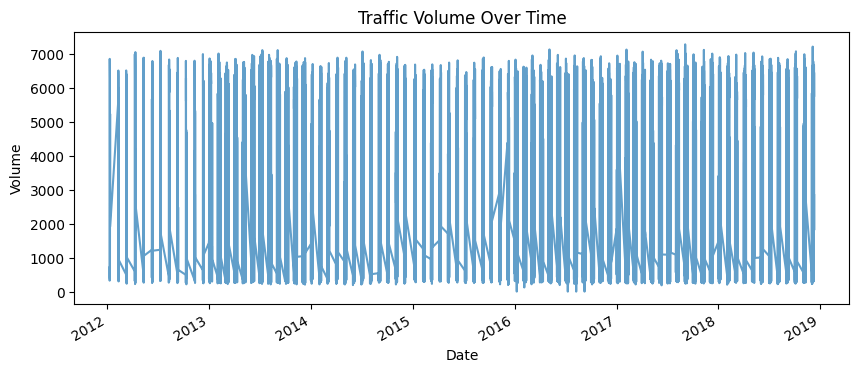

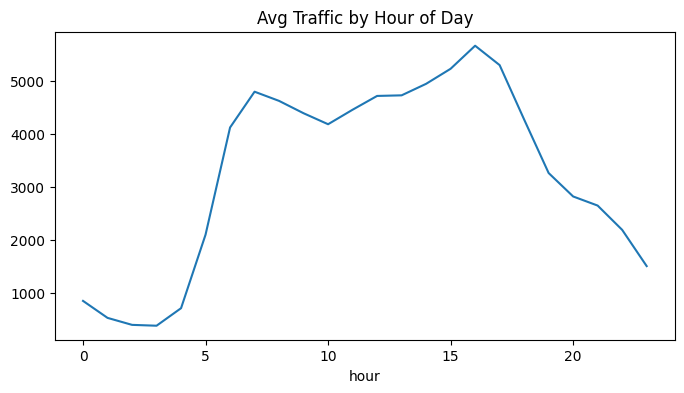

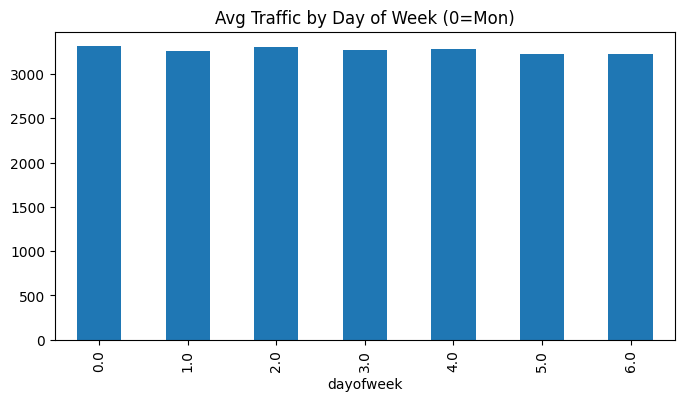

ValueError: Could not interpret value `weather_main` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

In [ ]:
run_eda(df)

In [ ]:
#save to new csv
df.to_csv('data_cleaned.csv', index=False)

NameError: name 'df' is not defined

In [ ]:
df['weather_description_scattered clouds']